In [ ]:
# Importing the necessary libraries
import pandas as pd # pandas is used for data manipulation and analysis
import numpy as np  # numpy is used for numerical computations and handling arrays

In [ ]:
# Reading the CSV file 'df_copy_unique.csv' into a pandas DataFrame
df=pd.read_csv("df_copy_unique.csv")

In [ ]:
# Creating a copy of the original DataFrame to work with separately
df_copy=df.copy()

In [ ]:
# Function to check missing values, null values, and zero counts in the DataFrame
def check_missing_values(df):
    # Count the number of missing values (NaN) in the DataFrame
    missing_counts = df.isnull().sum()  # Checks for NaN values and counts them

    # Count the number of zeros in the DataFrame
    zero_counts = (df == 0).sum()  # Looks for cells with value 0 and counts them

    # Count the number of empty strings in the DataFrame
    empty_string_counts = (df == '').sum()  # Looks for cells with empty strings and counts them

    # Create a new DataFrame to store the results of the counts
    result = pd.DataFrame({
        'Missing (NaN) Count': missing_counts,  # Number of NaN values per column
        'Zero Count': zero_counts,  # Number of zeros per column
        'Empty String Count': empty_string_counts  # Number of empty strings per column
    })

    # Return the result DataFrame
    return result

# Apply the function to your DataFrame 'df_copy' to check missing, zero, and empty string counts
missing_values_report = check_missing_values(df_copy)

# Print the report of missing, zero, and empty string counts for each column
print(missing_values_report)

                       Missing (NaN) Count  Zero Count  Empty String Count
mileage                                  0       44499                   0
price                                    0        1446                   0
model_year                               0           0                   0
make                                     0           0                   0
model                                    0           0                   0
series                                   0           0                   0
style                                    0           0                   0
certified                                0      107742                   0
price_analysis                           0       98748                   0
drivetrain_from_vin                      0           0                   0
engine_from_vin                          0           0                   0
transmission_from_vin                    0           0                   0
fuel_type_from_vin       

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import joblib


Loads all necessary libraries for data processing, modeling, and evaluation.

In [ ]:
# Load the dataset
df = pd.read_csv("df_copy_unique.csv")

# Make a copy of the dataset
df_copy = df.copy()

# Check for missing values
if df_copy.isnull().sum().sum() > 0:
    print("⚠️ Warning: Missing values detected! Consider handling them before training.")

# Identify categorical columns (excluding the target)
categorical_columns = df_copy.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('transmission_from_vin')  # Exclude target variable

# Apply Label Encoding to categorical features
label_encoder = LabelEncoder()
for col in categorical_columns:
    df_copy[col] = label_encoder.fit_transform(df_copy[col])

# Ensure target variable 'transmission_from_vin' is categorical
df_copy['transmission_from_vin'] = df_copy['transmission_from_vin'].astype('category')


Handles missing values, encodes categorical variables, and ensures correct data types.

In [ ]:
# Split into features (X) and target (y)
# Remove 'certified' column

X = df_copy.drop(columns=['transmission_from_vin', 'certified'])  # Features
y = df_copy['transmission_from_vin']  # Target variable


# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert y_train to categorical
y_train = y_train.astype('category')

# Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [ ]:
#count the value of each transmission from vin
y_train_balanced.value_counts()


,count
transmission_from_vin,
A,84441
M,84441


Balances the dataset using SMOTE, ensuring fair model training.

In [ ]:
# Save the datasets to CSV filesvin type

X_train_balanced.to_csv("X_train_balanced.csv", index=False)
y_train_balanced.to_csv("y_train_balanced.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("\n✅ Data preprocessing completed and files saved!")



✅ Data preprocessing completed and files saved!


Saves the balanced dataset for future use.

In [ ]:
# Convert target variable to numeric values
y_train_balanced = y_train_balanced.cat.rename_categories({'A': 1, 'M': 0})
y_test = y_test.cat.rename_categories({'A': 1, 'M': 0})

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [100, 300],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [1, 5]  # Adjust weight for class imbalance
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Use Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    xgb_model, param_grid, cv=skf, scoring='f1_weighted',
    n_jobs=-1, verbose=1, n_iter=16, random_state=42
)
# Train with the best hyperparameters
random_search.fit(X_train_balanced, y_train_balanced)

# Best parameters found
print("\n✅ Best Hyperparameters:", random_search.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Best Hyperparameters: {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.8}


In [ ]:

# Train XGBoost with default parameters (Before Hyperparameter Tuning)
default_xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
default_xgb_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on test data (Before Tuning)
y_pred_default = default_xgb_model.predict(X_test)

# Evaluate the default model
print("\n🚀 Performance Before Tuning:")
print("Classification Report (Before Tuning):\n", classification_report(y_test, y_pred_default))



### 🔥 Impact of Hyperparameter Tuning on Model Performance
1. `max_depth = 6` → Prevents overfitting by limiting tree depth.
2. `learning_rate = 0.3` → Allows faster convergence and avoids overshooting.
3. `n_estimators = 300` → More boosting rounds, improving accuracy.
4. `subsample = 0.8` → Uses 80% of training data in each boosting iteration, reducing variance.
5. `scale_pos_weight = 5` → Adjusts for class imbalance, improving recall for the minority class.
6. `colsample_bytree = 0.8` → Uses only 80% of features per tree, improving generalization and preventing overfitting.


Uses RandomizedSearchCV for hyperparameter tuning to improve performance.

In [ ]:
# Train best model
best_model = xgb.XGBClassifier(**random_search.best_params_, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train_balanced, y_train_balanced)

# Save model for reuse
joblib.dump(best_model, "xgboost_model.pkl")
print("\n✅ Model saved as xgboost_model.pkl")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Model saved as xgboost_model.pkl


In [ ]:

# Make predictions after tuning
y_pred_best = best_model.predict(X_test)

# Evaluate the optimized model
print("\n✅ Performance After Tuning:")
print("Classification Report (After Tuning):\n", classification_report(y_test, y_pred_best))

# Compare Accuracy Before and After
from sklearn.metrics import accuracy_score

accuracy_before = accuracy_score(y_test, y_pred_default)
accuracy_after = accuracy_score(y_test, y_pred_best)

print(f"\n📊 Accuracy Before Tuning: {accuracy_before:.4f}")
print(f"📈 Accuracy After Tuning: {accuracy_after:.4f}")


Saves the trained model for future predictions.

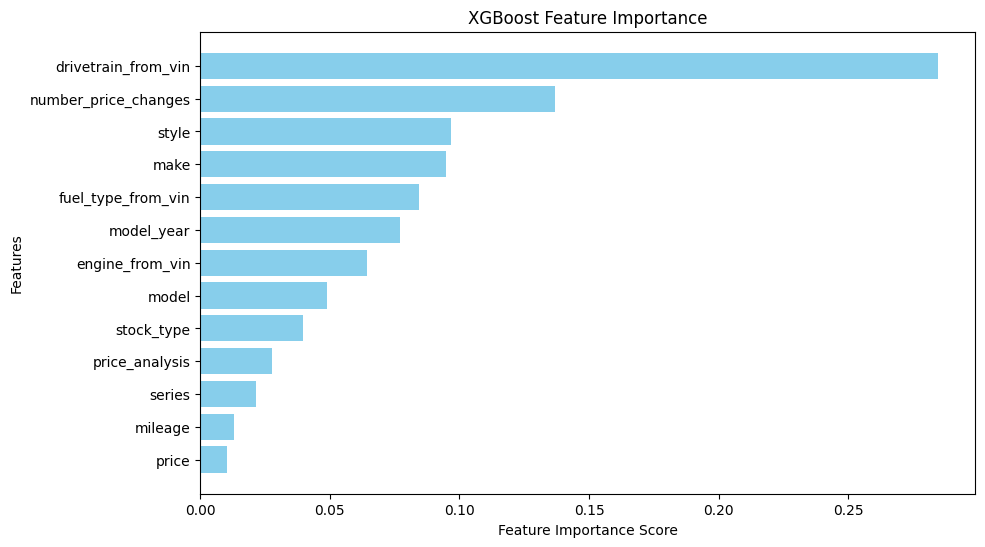

In [ ]:
# Get feature importance scores
importance = best_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': importance})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Save feature importance as CSV
feature_importance_df.to_csv("feature_importance.csv", index=False)


Displays and saves feature importance for interpretability.


✅ Results for Threshold = 0.5
Confusion Matrix:
 [[  565    62]
 [   42 21069]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       627
           1       1.00      1.00      1.00     21111

    accuracy                           1.00     21738
   macro avg       0.96      0.95      0.96     21738
weighted avg       1.00      1.00      1.00     21738


✅ Weighted F1-score: 0.9952


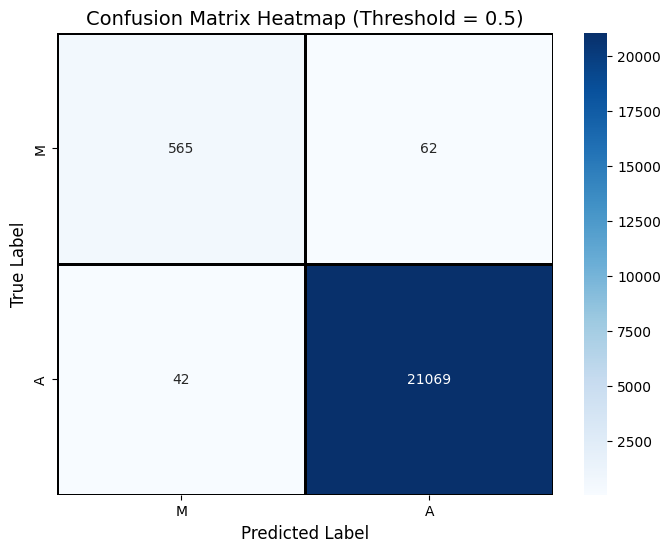


✅ Results for Threshold = 0.52
Confusion Matrix:
 [[  566    61]
 [   44 21067]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       627
           1       1.00      1.00      1.00     21111

    accuracy                           1.00     21738
   macro avg       0.96      0.95      0.96     21738
weighted avg       1.00      1.00      1.00     21738


✅ Weighted F1-score: 0.9951


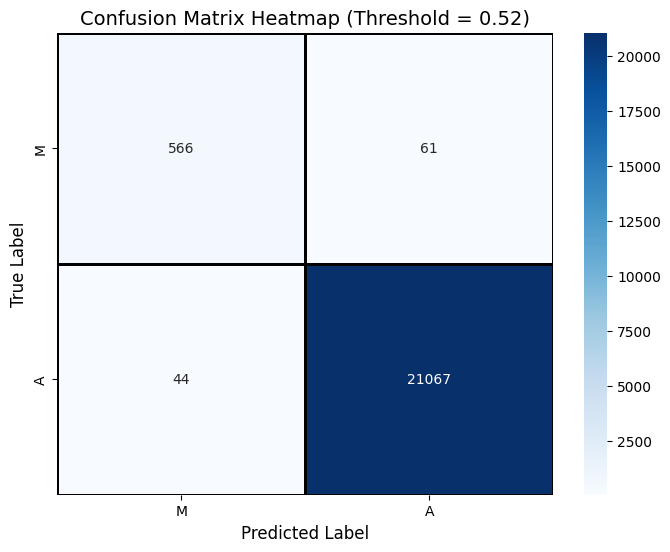


✅ Results for Threshold = 0.55
Confusion Matrix:
 [[  571    56]
 [   45 21066]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       627
           1       1.00      1.00      1.00     21111

    accuracy                           1.00     21738
   macro avg       0.96      0.95      0.96     21738
weighted avg       1.00      1.00      1.00     21738


✅ Weighted F1-score: 0.9953


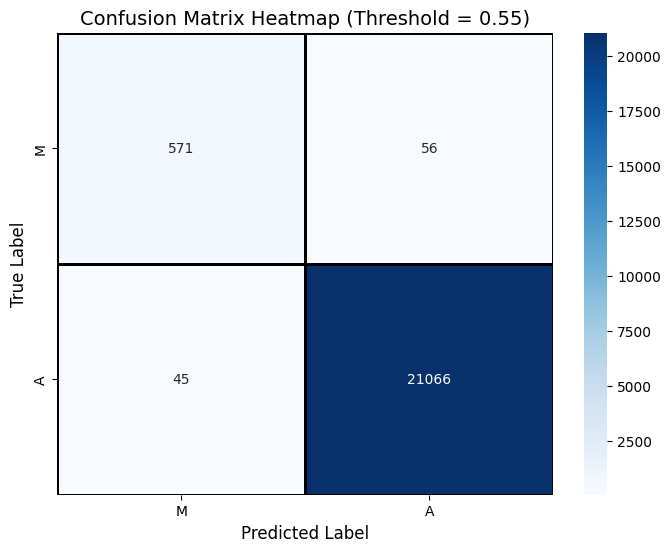


✅ Results for Threshold = 0.6
Confusion Matrix:
 [[  574    53]
 [   50 21061]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       627
           1       1.00      1.00      1.00     21111

    accuracy                           1.00     21738
   macro avg       0.96      0.96      0.96     21738
weighted avg       1.00      1.00      1.00     21738


✅ Weighted F1-score: 0.9953


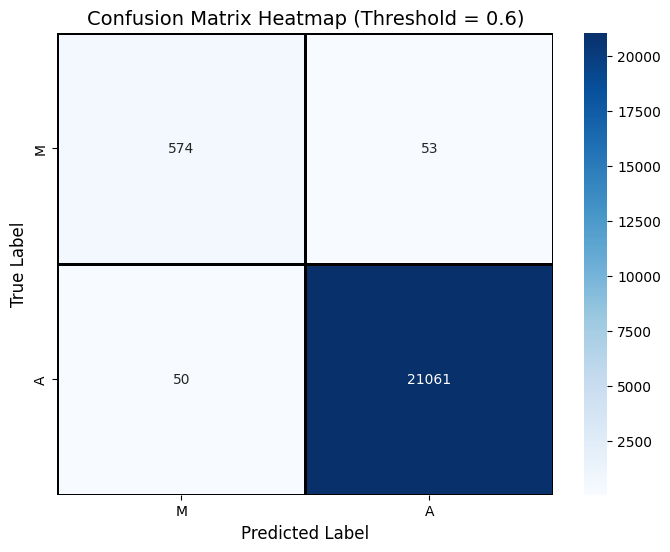


✅ Model training and evaluation completed!


In [ ]:
# Make predictions using probability threshold
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for class 'A'

# Experiment with different threshold values to balance precision & recall
thresholds = [0.50, 0.52, 0.55, 0.60]

for threshold in thresholds:
    # Adjust threshold and get new predictions
    y_pred_adjusted = (y_proba > threshold).astype(int)

    # Evaluate model performance
    cm = confusion_matrix(y_test, y_pred_adjusted)
    print(f"\n✅ Results for Threshold = {threshold}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred_adjusted))

    # Compute weighted F1-score
    f1 = f1_score(y_test, y_pred_adjusted, average='weighted')
    print(f"\n✅ Weighted F1-score: {f1:.4f}")

    # Plot Confusion Matrix Heatmap
    labels = ['M', 'A'] if 0 in y_test.unique() and 1 in y_test.unique() else sorted(y_test.unique())

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor='black', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix Heatmap (Threshold = {threshold})", fontsize=14)
    plt.show()

print("\n✅ Model training and evaluation completed!")

Uses threshold-based predictions, evaluates with confusion matrix, and visualizes with heatmap.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# ============================================
# 🔥 Hyperparameter Tuning - Decision Tree 🔥
# ============================================

from sklearn.model_selection import GridSearchCV

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [5, 10, 20, None],  # Controls tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5]  # Minimum samples required in a leaf node
}

# Initialize Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Perform Grid Search for optimal hyperparameters
dt_grid = GridSearchCV(dt, dt_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
dt_grid.fit(X_train_balanced, y_train_balanced)

# Display the best parameters
print("\n✅ Best Parameters - Decision Tree:", dt_grid.best_params_)

# ============================================
#  Train & Evaluate Optimized Decision Tree Classifier
# ============================================

# Train Decision Tree model with best parameters
best_dt = DecisionTreeClassifier(**dt_grid.best_params_, random_state=42)
best_dt.fit(X_train_balanced, y_train_balanced)

# Make Predictions on the Test Set
y_pred_dt = best_dt.predict(X_test)

# Evaluate Model Performance
print("Confusion Matrix - Decision Tree:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report - Decision Tree:\n", classification_report(y_test, y_pred_dt))

print("\n✅ Optimized Decision Tree Model trained and evaluated successfully!")


Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ Best Parameters - Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Confusion Matrix - Decision Tree:
 [[  585    42]
 [  138 20973]]

Classification Report - Decision Tree:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87       627
           1       1.00      0.99      1.00     21111

    accuracy                           0.99     21738
   macro avg       0.90      0.96      0.93     21738
weighted avg       0.99      0.99      0.99     21738


✅ Optimized Decision Tree Model trained and evaluated successfully!


In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [5, 10, 20, None],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5]  # Minimum samples required in a leaf node
}


We test different values to find the best settings for our Random Forest model.



In [ ]:
rf = RandomForestClassifier(random_state=42)


This initializes a RandomForestClassifier with a fixed random state (42) for reproducibility.

GridSearchCV tries different combinations from rf_param_grid
cv=3 → Uses 3-fold cross-validation
scoring='f1_weighted' → Optimizes for F1-score
n_jobs=-1 → Uses all CPU cores for speed
verbose=1 → Prints progress messages

In [ ]:


# Perform Randomized Search
rf_random_search = RandomizedSearchCV(
    rf, rf_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1, n_iter=10, random_state=42
)
rf_random_search.fit(X_train_balanced, y_train_balanced)

# Best parameters
print("Best Parameters - Random Forest:", rf_random_search.best_params_)




Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters - Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [ ]:

# Train XGBoost with default parameters (Before Hyperparameter Tuning)
default_xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
default_xgb_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on test data (Before Tuning)
y_pred_default = default_xgb_model.predict(X_test)

# Evaluate the default model
print("\n🚀 Performance Before Tuning:")
print("Classification Report (Before Tuning):\n", classification_report(y_test, y_pred_default))


In [ ]:
# Train with best parameters
best_rf = RandomForestClassifier(**rf_random_search.best_params_, random_state=42)
best_rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
# Import RandomForest
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Make Predictions on the Test Set
y_pred_rf = rf_model.predict(X_test)

# Evaluate Model Performance
print("Confusion Matrix - Random Forest:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report - Random Forest:\n", classification_report(y_test, y_pred_rf))

print("\n✅ Random Forest Model trained and evaluated successfully!")

Confusion Matrix - Random Forest:
 [[  583    44]
 [   93 21018]]

Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       627
           1       1.00      1.00      1.00     21111

    accuracy                           0.99     21738
   macro avg       0.93      0.96      0.95     21738
weighted avg       0.99      0.99      0.99     21738


✅ Random Forest Model trained and evaluated successfully!


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:34:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


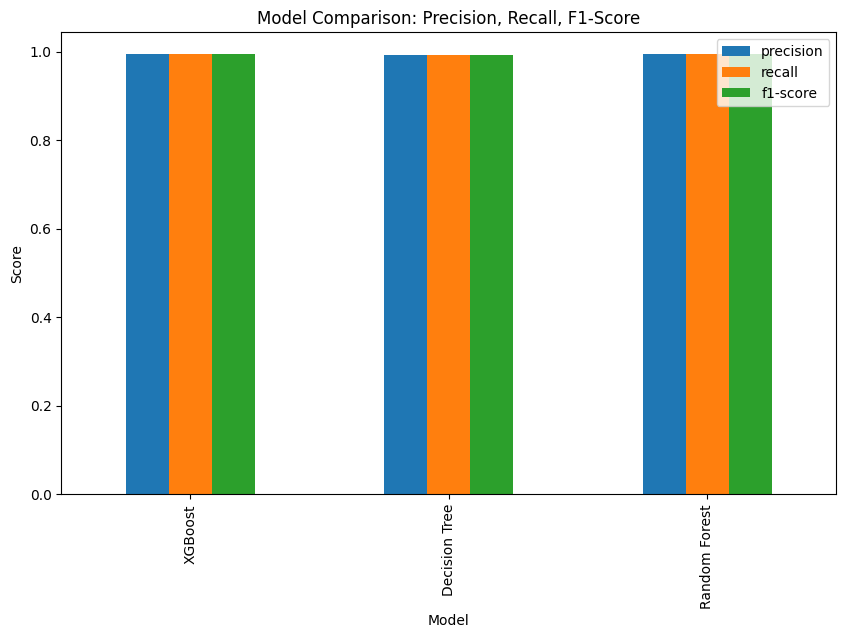

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get classification reports for all models
xgb_model.fit(X_train_balanced, y_train_balanced)  # Fit the xgb_model here
xgb_report = classification_report(y_test, xgb_model.predict(X_test), output_dict=True)
dt_report = classification_report(y_test, best_dt.predict(X_test), output_dict=True)
rf_report = classification_report(y_test, best_rf.predict(X_test), output_dict=True)

# Create DataFrame for comparison
df_comparison = pd.DataFrame({
    "XGBoost": xgb_report["weighted avg"],
    "Decision Tree": dt_report["weighted avg"],
    "Random Forest": rf_report["weighted avg"]
}).T

# Select important metrics
df_comparison = df_comparison[["precision", "recall", "f1-score"]]

# Plot bar chart for model comparison
df_comparison.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison: Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.xlabel("Model")
plt.show()


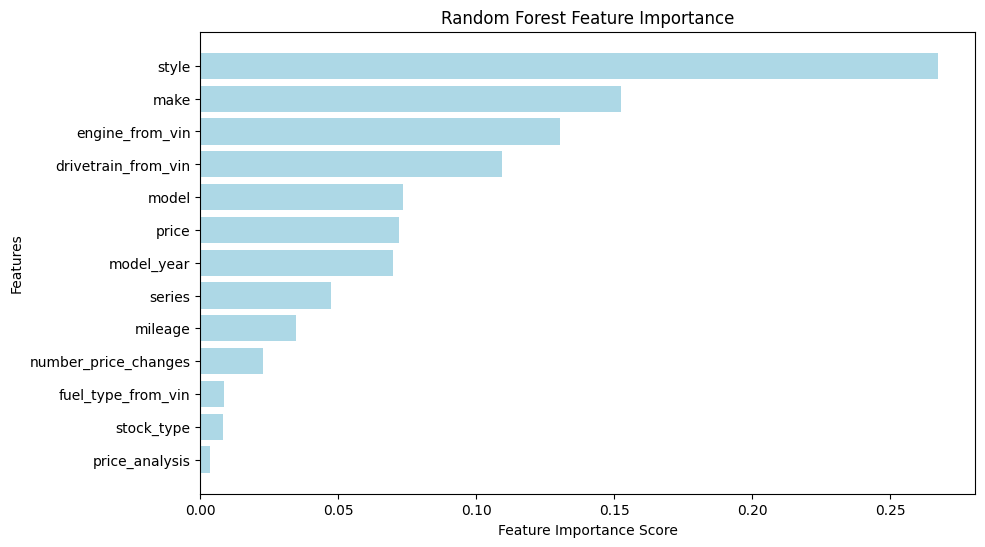

In [ ]:
# Feature Importance for Random Forest
rf_importance = best_rf.feature_importances_
rf_features = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': rf_importance})
rf_features = rf_features.sort_values(by='Importance', ascending=False)

# Plot Feature Importance for Random Forest
plt.figure(figsize=(10,6))
plt.barh(rf_features['Feature'], rf_features['Importance'], color='lightblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

sns.set_theme(style="whitegrid")

# Assuming you have trained models: xgb_model, best_rf, best_dt
# Get predictions for each model
y_pred1 = xgb_model.predict(X_test)  # XGBoost predictions
y_pred2 = best_rf.predict(X_test)  # Random Forest predictions
y_pred3 = best_dt.predict(X_test)  # Decision Tree predictions

# Create a dictionary to store metrics for each model
metrics_data = {
    'Model': [],
    'Metric': [],
    'Score': []
}

# Calculate metrics for each model and add to the dictionary
for model_name, y_pred in zip(['model1', 'model2', 'model3'], [y_pred1, y_pred2, y_pred3]):
    metrics_data['Model'].extend([model_name] * 4)
    metrics_data['Metric'].extend(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
    metrics_data['Score'].extend([
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ])

# Create a dictionary to map model names to labels
model_labels = {
    'model1': 'XGBoost',
    'model2': 'Random Forest',
    'model3': 'Decision Tree'
}

# Create a DataFrame from the metrics data
metrics_df = pd.DataFrame(metrics_data)

# Apply the mapping to the 'Model' column of metrics_df
metrics_df['Model'] = metrics_df['Model'].map(model_labels)

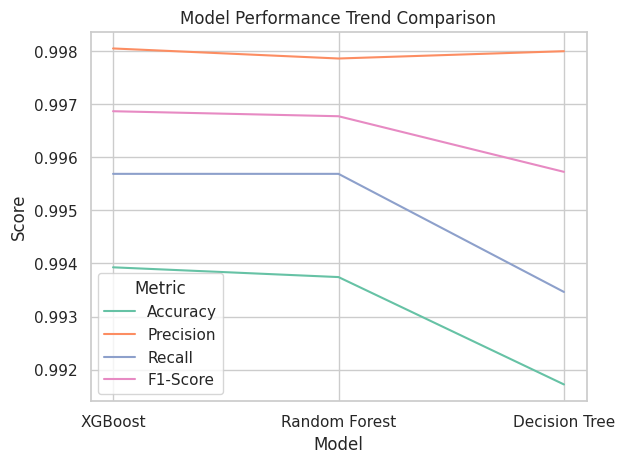

In [ ]:
# Creating a lineplot
sns.lineplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette="Set2")
plt.title('Model Performance Trend Comparison')
plt.show()

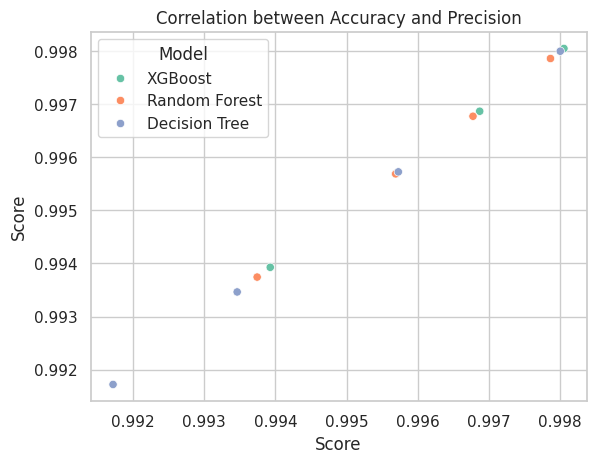

In [ ]:
# Creating a scatterplot
sns.set_theme(style='whitegrid')
sns.scatterplot(x='Score', y='Score', hue='Model', data=metrics_df, palette="Set2")
plt.title('Correlation between Accuracy and Precision')
plt.show()

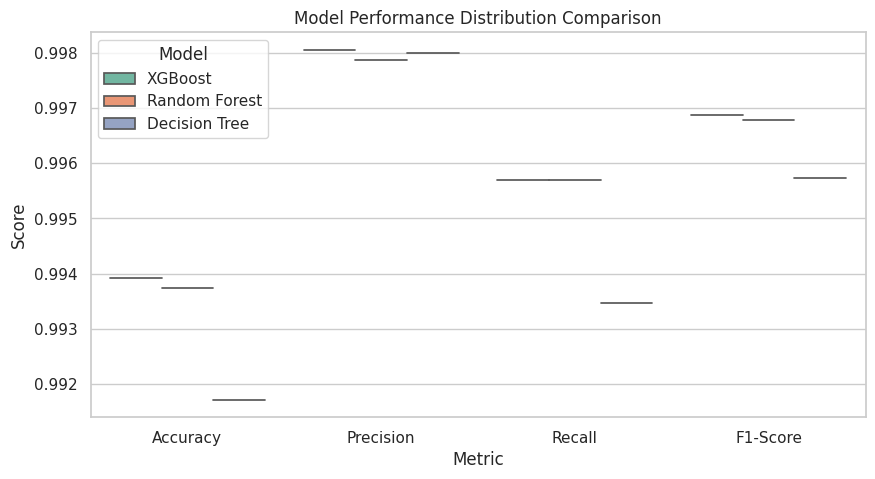

In [ ]:
# Creating a Violinplot
plt.figure(figsize=(10,5))
sns.violinplot(x='Metric', y='Score', hue='Model', data=metrics_df, palette="Set2")
plt.title('Model Performance Distribution Comparison')
plt.show()

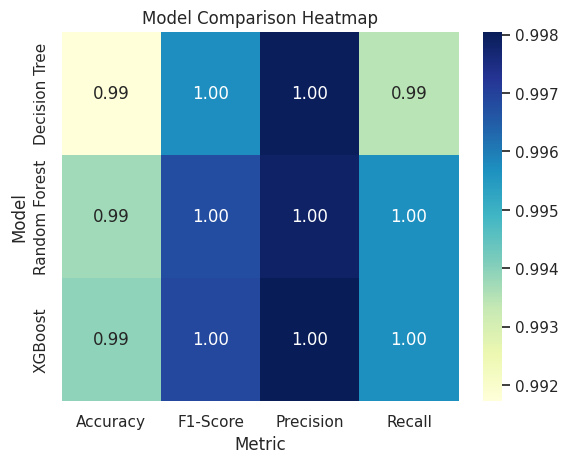

In [ ]:
# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = metrics_df.pivot(index='Model', columns='Metric', values='Score')

sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")  # annot=True to display values, cmap for color scheme
plt.title('Model Comparison Heatmap')
plt.show()